In [1]:
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch.onnx
import matplotlib.pyplot as plt
import pickle as p
from landing_club_prepost import LandingClubPrePost

pd.options.display.max_rows=999

In [2]:
FULL_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4.csv'
SMALL_SAMPLE_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_sample.csv'
SMALL_HEAD_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_head.csv'
MEDIUM_SAMPLE_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_medium_sample.csv'
MEDIUM_HEAD_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_medium_head.csv'
USED_DATASET_NAME = MEDIUM_HEAD_DATASET_NAME

Sample a few records for faster work

In [3]:
COL_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc', 'int_rate']
FEATURE_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc']
LABEL_NAME = 'int_rate'

## Data Preparation
Training and validation data preparation is combined in this class

In [4]:
%%writefile landing_club_dataset.py
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch.onnx
import matplotlib.pyplot as plt
import pickle as p
from landing_club_prepost import LandingClubPrePost


class Landing_Club_Dataset(Dataset):
    def __init__(self, file_path: str, col_label, col_names = []):
        self.sc_x = StandardScaler()
        self.sc_y = StandardScaler()
        self.one_hot_enc = OneHotEncoder(sparse=False)
        self.file_path = file_path
        self.col_label = col_label
        self.col_names = col_names
        self.read_and_preprocess_datafile()
        
    def read_and_preprocess_datafile(self):
        self.df = pd.read_csv(self.file_path, usecols = self.col_names)
        self.clean()
        self.split_features_and_labels() # split feature columns and label column
        self.encode_categorical_columns()
        self.split_train_test_and_standardize(test_size=.2)
        self.to_tensor()
        self.wrapper = LandingClubPrePost(self.sc_x, self.sc_y, self.one_hot_enc)
        self.write_prepost_pickle()
            
    def __getitem__(self, index: int):
        return (self.X_tsor[index], self.y_tsor[index])
    
    def __len__(self):
        return len(self.df)
    
    def to_numpy(self):
        return self.df.to_numpy()
    
    def to_tensor(self, with_grad=False):
        self.X_tsor = torch.tensor(DataFrame.to_numpy(self.X_df), requires_grad=with_grad)
        self.y_tsor = torch.tensor(self.y_df.to_numpy(), requires_grad=with_grad)
    
    def clean(self):
        self.df.dropna(inplace=True)
        return
    
    def encode_categorical_columns(self):
        categorical_cols = list(self.X_df.select_dtypes(include=['object']))
        for col in categorical_cols:
            categories = self.X_df[col].to_numpy().reshape(-1,1)
            oh_encoded = self.one_hot_enc.fit_transform(categories)
            oh_df = pd.DataFrame(oh_encoded, columns=self.one_hot_enc.get_feature_names_out())
            self.X_df = self.X_df.join(oh_df)
            self.X_df.drop(columns=[col], inplace=True)
            print('AAAAAAAA')
            print(self.X_df)
            # label_encoded = self.label_enc.fit_transform(self.X_df[col])
            # self.X_df[col] = label_encoded
            # self.X_df = pd.get_dummies(self.X_df, columns=['home_ownership'])

    def split_features_and_labels(self):
        self.X_df = self.df.drop(columns=[self.col_label])
        self.y_df = self.df[self.col_label]
        print(type(self.y_df))

    def split_train_test_and_standardize(self, test_size):
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = \
            train_test_split(self.X_df.values, self.y_df.values, test_size=test_size, shuffle=False)

        y_train_orig = y_train_orig.reshape(-1, 1)
        y_test_orig = y_test_orig.reshape(-1, 1)

        self.X_train = LandingClubPrePost.standardize(self.sc_x, X_train_orig, True)
        self.X_test = LandingClubPrePost.standardize(self.sc_x, X_test_orig, False)
        self.y_train = LandingClubPrePost.standardize(self.sc_y, y_train_orig, True)
        self.y_test = LandingClubPrePost.standardize(self.sc_y, y_test_orig, False)

    def get_train_dataset(self):
        X_train_tsor = torch.from_numpy(self.X_train.astype(np.float32))
        y_train_tsor = torch.from_numpy(self.y_train.astype(np.float32))
        return (X_train_tsor, y_train_tsor)

    def get_train_dataloader(self, batch_size):
        X_train_tsor = torch.from_numpy(self.X_train.astype(np.float32))
        y_train_tsor = torch.from_numpy(self.y_train.astype(np.float32))
        return DataLoader(TensorDataset(X_train_tsor, y_train_tsor), batch_size=batch_size)

    def get_test_dataset(self):
        X_test_tsor = torch.from_numpy(self.X_test.astype(np.float32))
        y_test_tsor = torch.from_numpy(self.y_test.astype(np.float32))
        return (X_test_tsor, y_test_tsor)

    def write_prepost_pickle(self):    
        wrapper_file = open('landing_club_prepost.pickle', 'wb')
        p.dump(self.wrapper, wrapper_file)
        wrapper_file.close()
    

Overwriting landing_club_dataset.py


In [5]:
feature_count = 5

class ClassModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 5)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(5, 1)

    def forward(self, X):
        x = self.fc1(X)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

_class_model = ClassModel(feature_count, 1)
_seq_model = nn.Sequential(
    nn.Linear(feature_count, 5),
    nn.Sigmoid(),
    nn.Linear(5, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1)
)

model = _seq_model

Define training objects

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(lr=.3, params=model.parameters())

Train Model

In [7]:
from landing_club_dataset import Landing_Club_Dataset
dataset = Landing_Club_Dataset(USED_DATASET_NAME, LABEL_NAME, COL_NAMES)
train_dataloader = dataset.get_train_dataloader(batch_size=1000)
dataset.X_train

<class 'pandas.core.series.Series'>
AAAAAAAA
      loan_amnt  annual_inc  x0_MORTGAGE  x0_OWN  x0_RENT
0        3600.0     55000.0          1.0     0.0      0.0
1       24700.0     65000.0          1.0     0.0      0.0
2       20000.0     63000.0          1.0     0.0      0.0
3       35000.0    110000.0          1.0     0.0      0.0
4       10400.0    104433.0          1.0     0.0      0.0
...         ...         ...          ...     ...      ...
9995     5000.0     38000.0          0.0     0.0      1.0
9996    16000.0    100000.0          0.0     0.0      1.0
9997    24000.0     80000.0          1.0     0.0      0.0
9998    10000.0     45000.0          1.0     0.0      0.0
9999    21000.0     86000.0          1.0     0.0      0.0

[10000 rows x 5 columns]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-1.32962992, -0.36119385,  1.00350615, -0.35781501, -0.79665217],
       [ 1.08946913, -0.21215171,  1.00350615, -0.35781501, -0.79665217],
       [ 0.55061768, -0.24196014,  1.00350615, -0.35781501, -0.79665217],
       ...,
       [-0.36657627,  0.11574099,  1.00350615, -0.35781501, -0.79665217],
       [-0.16307386, -0.61456548, -0.9965061 , -0.35781501,  1.25525297],
       [-0.48122551, -0.70399076, -0.9965061 , -0.35781501,  1.25525297]])

In [8]:
# (X_train_tsor, y_train_tsor) = dataset.get_train_dataset()

# print(X_train_tsor[0:4])
# print(y_train_tsor[0:4])

losses = []
n_epochs = 500
model.train()
for epoch in range(n_epochs):
    batch_cnt = 0
    for batch in train_dataloader:
        print(f'Epoch {epoch}, Batch {batch_cnt}, Batchsize {len(batch[0])}')
        batch_cnt += 1
        (X_train_tsor, y_train_tsor) = batch
        outputs = model(X_train_tsor)
        loss = criterion(outputs, y_train_tsor)
        losses.append(loss)
        if (epoch % 300 == 0):
            with torch.no_grad():
                peek_output_element = 3
                print(f'Loss on epoch '
                        f'{epoch:04}: {loss.item():.4f} - '
                        f'interest rate: '
                        f'{dataset.sc_y.inverse_transform(outputs[peek_output_element].reshape(-1,1)).reshape(1).item():.4f}'
                        f'/ '
                        f'{dataset.sc_y.inverse_transform(y_train_tsor[peek_output_element].reshape(-1, 1)).reshape(1).item():.4f}'
                        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


Epoch 0, Batch 0, Batchsize 1000
Loss on epoch 0000: 1.0241 - interest rate: 11.9125/ 14.8500
Epoch 0, Batch 1, Batchsize 1000
Loss on epoch 0000: 1.0103 - interest rate: 12.0560/ 9.1700
Epoch 0, Batch 2, Batchsize 1000
Loss on epoch 0000: 1.0386 - interest rate: 12.5454/ 11.4800
Epoch 0, Batch 3, Batchsize 1000
Loss on epoch 0000: 0.9498 - interest rate: 12.4238/ 9.1700
Epoch 0, Batch 4, Batchsize 1000
Loss on epoch 0000: 1.0697 - interest rate: 12.0570/ 9.8000
Epoch 0, Batch 5, Batchsize 1000
Loss on epoch 0000: 1.0379 - interest rate: 12.5552/ 13.4400
Epoch 0, Batch 6, Batchsize 1000
Loss on epoch 0000: 0.9501 - interest rate: 12.2786/ 13.9900
Epoch 0, Batch 7, Batchsize 1000
Loss on epoch 0000: 0.9394 - interest rate: 12.4625/ 13.9900
Epoch 1, Batch 0, Batchsize 1000
Epoch 1, Batch 1, Batchsize 1000
Epoch 1, Batch 2, Batchsize 1000
Epoch 1, Batch 3, Batchsize 1000
Epoch 1, Batch 4, Batchsize 1000
Epoch 1, Batch 5, Batchsize 1000
Epoch 1, Batch 6, Batchsize 1000
Epoch 1, Batch 7, Ba

Validate Predictions

Prediction / Test [0] = [[13.27983846]] / [[12.59000001]]
Prediction / Test [1] = [[12.85907798]] / [[13.67000003]]
Prediction / Test [2] = [[10.52774422]] / [[9.75999988]]
Prediction / Test [3] = [[12.41666061]] / [[7.25999976]]
Prediction / Test [4] = [[11.33317647]] / [[13.17999997]]
Prediction / Test [5] = [[10.49014155]] / [[6.23999981]]
Prediction / Test [6] = [[13.17536572]] / [[18.20000025]]
Prediction / Test [7] = [[14.36641797]] / [[17.56999987]]
Prediction / Test [8] = [[12.35653459]] / [[12.59000001]]
Prediction / Test [9] = [[14.35487685]] / [[16.98999977]]


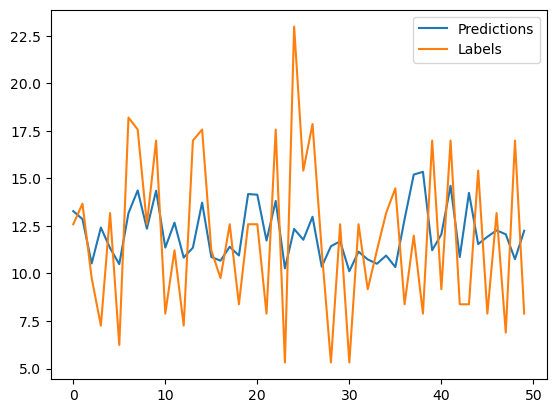

In [9]:
with torch.no_grad():
    model.eval()
    (X_test_tsor, y_test_tsor) = dataset.get_test_dataset()

    preds = model.forward(X_test_tsor)
    # X_test_feat_0 = X_test[2:, 0:1].reshape(-1)
    preds_decoded = dataset.sc_y.inverse_transform(preds)
    y_test_tsor_decoded = dataset.sc_y.inverse_transform(y_test_tsor)
    for i in range(0, 10):
        print(f'Prediction / Test [{i}] = '
              f'{preds_decoded[i].reshape(-1, 1)} / '
              f'{y_test_tsor_decoded[i].reshape(-1, 1)}')
    plt.cla()
    plt.plot(preds_decoded[0:50], label='Predictions')
    plt.plot(y_test_tsor_decoded[0:50], label='Labels')
    plt.legend()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f'Shape of y_test_tsor: {np.shape(y_test_tsor_decoded)}  -  preds: {np.shape(preds_decoded)}')
acc_score = mean_absolute_error(y_test_tsor_decoded, preds_decoded)
print(f'Accuracy: {acc_score}')

Shape of y_test_tsor: (2000, 1)  -  preds: (2000, 1)
Accuracy: 3.139331240852183


Export ONNX Model

In [11]:
model.eval()
_dummy_input = torch.tensor([[0.1, 0.1, 0.1, 0.1, 0.1]])
torch.onnx.export(model, 
                  _dummy_input, 
                  "landing_club_model.onnx",
                  verbose=False,
                  input_names=["features"],
                  output_names=["prediction"],
                  export_params=True)


Test Wrapper